# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
# Kernel will die if we don't run this line
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

%load_ext tensorboard

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# # Where to save the figures
# PROJECT_ROOT_DIR = "."
# CHAPTER_ID = "deep"
# IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
# os.makedirs(IMAGES_PATH, exist_ok=True)

# def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
#     path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
#     print("Saving figure", fig_id)
#     if tight_layout:
#         plt.tight_layout()
#     plt.savefig(path, format=fig_extension, dpi=resolution

In [2]:
import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# %matplotlib inline

In [3]:
# import tensorflow as tf
# from tensorflow import keras

# Vanishing/Exploding Gradients Problems 
- The **Vanishing Gradients** Problem
    - When training deep neural networks, gradients often get smaller and smaller as the algorithm progresses down to the lower layers. 
    - As a result, the Gradient Descent update leaves the lower layer connection weights virtually unchanged, and training never converges to a good solution.
- The **Exploding Gradients** Problem
    - In some cases, the opposite can happen: the gradients can grow bigger and bigger, so many layers get insanely large weight updates and the algorithm diverges.

# Glorot and He Initialization
- To significantly alleviate the Vanishing/Exploding Gradient problems, Glorot and Bengio proposed that we need the signal to flow properly in both directions.
- For the signal to flow properly, we need the **variance of the outputs** of each layer to be **equal** to the **variance of its inputs**, and we also need the **gradients to have equal variance** before and after flowing through a layer in the reverse direction. 
- It is actually not possible to guarantee both unless the layer has **an equal number of inputs and neurons** (these numbers are called the **fan-in** and **fan-out** of the layer), but they proposed a good compromise that has proven to work very well in practice - **Glorot (Xavier) Initialization**.
    - The connection weights of each layer must be initialized randomly as:
        - **Normal distribution** with mean 0 and variance $\sigma^2 = 1/fan_{avg}$
        - Or a **uniform distribution** between $-r$ and $+r$, with $r = \sqrt{\frac{3}{fan_{avg}}}$ 

In [4]:
[name for name in dir(keras.initializers) if not name.startswith("_")]

['Constant',
 'GlorotNormal',
 'GlorotUniform',
 'Identity',
 'Initializer',
 'Ones',
 'Orthogonal',
 'RandomNormal',
 'RandomUniform',
 'TruncatedNormal',
 'VarianceScaling',
 'Zeros',
 'constant',
 'deserialize',
 'get',
 'glorot_normal',
 'glorot_uniform',
 'he_normal',
 'he_uniform',
 'identity',
 'lecun_normal',
 'lecun_uniform',
 'ones',
 'orthogonal',
 'serialize',
 'zeros']

## He Initialization
- Activation functions: ReLU & variants
- $\sigma^2$ (normal): $\frac{2}{fan_{in}}$

In [5]:
keras.layers.Dense(10, activation='relu', kernel_initializer='he_normal')

- If you want **He initialization** with a **uniform distribution**, but based on $fan_{avg}$ rather than $fan_{in}$, you can use the `VarianceScaling` initializer.

In [6]:
init = keras.initializers.VarianceScaling(scale=2., mode='fan_avg', distribution='uniform')
keras.layers.Dense(10, activation='relu', kernel_initializer=init)

## Summary - Initialization parameters for each type of activation function
- **Glorot**
    - Activation functions: None, Tanh, Logistic, Softmax
    - $\sigma^2 (Normal) = 1/fan_{avg}$
- **He**
    - Activation functions: ReLU & variants
    - $\sigma^2 (Normal) = 2/fan_{in}$
- **LeCun**
    - Activation functions: SELU
    - $\sigma^2 (Normal) = 1/fan_{in}$

# Nonsaturating Activating Functions
- Although behavoring well in most deep learning models, the ReLU activation function is not perfect. It suffers from a problem known as the **dying ReLUs**. 
    - During training, some neurons effectively die, meaning they stop outputting anything other than 0. 
    - A neuron dies when its weights get tweaked in such a way that **the weighted sum of its inputs are negative for all instances** in the training set. 
    - When this happens, it just **keeps outputting 0s**, and gradient descent does not affect it anymore since the gradient of the ReLU function is 0 when its input is negative.
    
## Leaky ReLU
- To solve this problem, you may want to use a variant of the ReLU function, such as the **leaky ReLU**. 
    - This function is defined as $LeakyReLU_\alpha(z) = max(\alpha z, z)$. 
        - The hyperparameter $\alpha$ defines how much the function “leaks”: it is the slope of the function for $z < 0$, and is typically set to 0.01. 
        - This small slope ensures that **leaky ReLUs never die**.

In [7]:
def leaky_relu(z, alpha=0.01):
    return np.maximum(alpha*z, z)

[-5, 5, -0.5, 4.2]

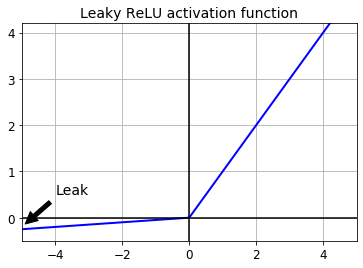

In [8]:
z = np.linspace(-5, 5, 200)

plt.plot(z, leaky_relu(z, 0.05), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([0, 0], [-0.5, 4.2], 'k-')
plt.grid(True)
props = dict(facecolor='black', shrink=0.1)
plt.annotate('Leak', xytext=(-3.5, 0.5), xy=(-5, -0.2), arrowprops=props, fontsize=14, ha="center")
plt.title("Leaky ReLU activation function", fontsize=14)
plt.axis([-5, 5, -0.5, 4.2])

In [9]:
[m for m in dir(keras.activations) if not m.startswith('_')]

['deserialize',
 'elu',
 'exponential',
 'get',
 'hard_sigmoid',
 'linear',
 'relu',
 'selu',
 'serialize',
 'sigmoid',
 'softmax',
 'softplus',
 'softsign',
 'tanh']

- Let's train a neural network on Fashion MNIST using the **Leaky ReLU**.

In [10]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

X_train_full = X_train_full / 255.0
X_test = X_test / 255.0
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]

In [11]:
X_train.shape

(55000, 28, 28)

In [12]:
tf.random.set_seed(42)
np.random.seed(42)

model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28,28]))

model.add(keras.layers.Dense(300, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU())

model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
model.add(keras.layers.LeakyReLU())

model.add(keras.layers.Dense(10, activation='softmax'))


# tf.random.set_seed(42)
# np.random.seed(42)

# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, kernel_initializer="he_normal"),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(100, kernel_initializer="he_normal"),
#     keras.layers.LeakyReLU(),
#     keras.layers.Dense(10, activation="softmax")
# ])

In [13]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# model.compile(loss="sparse_categorical_crossentropy",
#               optimizer=keras.optimizers.SGD(lr=1e-3),
#               metrics=["accuracy"])

In [14]:
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

- **Randomized ReLU (RReLU)**
    - $\alpha$ is picked randomly
- **Parametric Leaky ReLU (PReLU)**
    - $\alpha$ is authorized to be learned during training.
    - Instead of being a hyperparameter, $\alpha$ becomes a parameter that can be modified by backpropagation like any other parameter.

In [15]:
tf.random.set_seed(42)
np.random.seed(42)

In [16]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())

model.add(keras.layers.Dense(100, kernel_initializer='he_normal'))
model.add(keras.layers.PReLU())

model.add(keras.layers.Dense(10, activation='softmax'))

In [17]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [18]:
# history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))

## Exponential Linear Unit (ELU)
- $ELU_\alpha (z) = \begin{cases} \alpha (exp(z) - 1) & z < 0 \\ z & z\geqslant 0 \end{cases}$

In [19]:
def elu(z, alpha=1):
    return np.where(z < 0, alpha*(np.exp(z)-1), z)

[-5, 5, -2.2, 3.2]

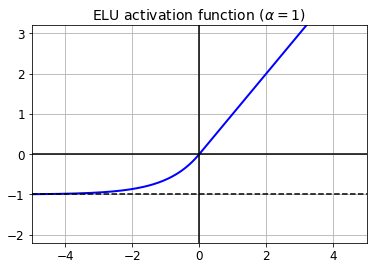

In [20]:
plt.plot(z, elu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1, -1], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title(r"ELU activation function ($\alpha=1$)", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

- We implement ELU in TensorFlow by specifying the activation function when building each layer.

In [21]:
keras.layers.Dense(10, activation='elu')

## SELU
- A scaled version of the ELU activation function: $SELU_{scale, alpha}(z) = scale \times ELU_{alpha}(z)$
- This activation function was proposed in this great paper by Günter Klambauer, Thomas Unterthiner and Andreas Mayr, published in June 2017. 
- During training, a neural network composed **exclusively** of a stack of **dense layers** using the **SELU activation function** and **LeCun initialization** will **self-normalize**. 
    - The output of each layer will tend to preserve the **same mean and variance** during training, which solves the vanishing/exploding gradients problem. 
- As a result, **SELU function outperforms** the other activation functions very significantly for such neural nets. 
- Unfortunately, the self-normalizing property of the SELU activation function is easily broken: you cannot use $l^1$ or $l^2$ regularization, regular dropout, max-norm, skip connections or other non-sequential topologies (so recurrent neural networks won't self-normalize). 
    - However, in practice it works quite well with **sequential ANNs**. 
    - If you break self-normalization, SELU will not necessarily outperform other activation functions.

In [22]:
from scipy.special import erfc

# alpha and scale to self normalize with mean 0 and standard deviation 1
# (see equation 14 in the paper):
alpha_0_1 = -np.sqrt(2 / np.pi) / (erfc(1/np.sqrt(2)) * np.exp(1/2) - 1)
scale_0_1 = (1 - erfc(1 / np.sqrt(2)) * np.sqrt(np.e)) * np.sqrt(2 * np.pi) * (2 * erfc(np.sqrt(2))*np.e**2 + np.pi*erfc(1/np.sqrt(2))**2*np.e - 2*(2+np.pi)*erfc(1/np.sqrt(2))*np.sqrt(np.e)+np.pi+2)**(-1/2)

In [23]:
def selu(z, scale=scale_0_1, alpha=alpha_0_1):
    return scale * elu(z, alpha)

[-5, 5, -2.2, 3.2]

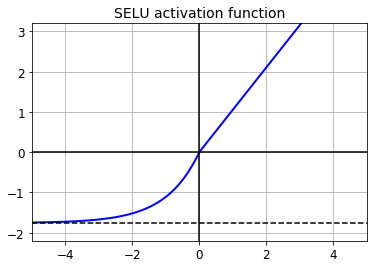

In [24]:
plt.plot(z, selu(z), "b-", linewidth=2)
plt.plot([-5, 5], [0, 0], 'k-')
plt.plot([-5, 5], [-1.758, -1.758], 'k--')
plt.plot([0, 0], [-2.2, 3.2], 'k-')
plt.grid(True)
plt.title("SELU activation function", fontsize=14)
plt.axis([-5, 5, -2.2, 3.2])

- By default, the SELU hyperparameters (scale and alpha) are tuned in such a way that the **mean output of each neuron** remains **close to 0**, and the **standard deviation** remains **close to 1** (assuming the **inputs are standardized with mean 0 and standard deviation 1** too). 
- Using this activation function, even a 1,000 layer deep neural network preserves roughly mean 0 and standard deviation 1 across all layers, avoiding the exploding/vanishing gradients problem.

In [25]:
np.random.seed(42)
Z = np.random.normal(size=(500, 100)) # assuming standardized inputs
for layer in range(1000):
    W = np.random.normal(size=(100, 100), scale=np.sqrt(1/100)) #LeCun initialization
    Z = selu(np.dot(Z, W))
#     print(Z.shape)
    means = np.mean(Z, axis=0).mean()
    stds = np.std(Z, axis=0).mean()
    if layer % 100 == 0:
        print("Layer {}: mean {:.2f}, standard deviation {:.2f}".format(layer, means, stds))

Layer 0: mean -0.00, standard deviation 1.00
Layer 100: mean 0.02, standard deviation 0.96
Layer 200: mean 0.01, standard deviation 0.90
Layer 300: mean -0.02, standard deviation 0.92
Layer 400: mean 0.05, standard deviation 0.89
Layer 500: mean 0.01, standard deviation 0.93
Layer 600: mean 0.02, standard deviation 0.92
Layer 700: mean -0.02, standard deviation 0.90
Layer 800: mean 0.05, standard deviation 0.83
Layer 900: mean 0.02, standard deviation 1.00


- To implement SELU activation, just set `activation="selu"` and `kernel_initializer="lecun_normal"` when creating a layer.

In [26]:
keras.layers.Dense(10, activation='selu', kernel_initializer='lecun_normal')

- Let's create a neural net for Fashion MNIST with 100 hidden layers, using the SELU activation function.

In [27]:
np.random.seed(42)
tf.random.set_seed(42)

In [28]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='selu', kernel_initializer='lecun_normal'))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal'))
    
model.add(keras.layers.Dense(10, activation='softmax'))

In [29]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=1e-3),
             metrics=['accuracy'])

- To train a model using the SELU activation function, we need to first **scale the inputs** to mean 0 and standard deviation 1.

In [30]:
pixel_means = X_train.mean(axis=0, keepdims=True)
pixel_std = X_train.std(axis=0, keepdims=True)

X_train_scaled = (X_train - pixel_means) / pixel_std
X_valid_scaled = (X_valid - pixel_means) / pixel_std
X_test_scaled = (X_test - pixel_means) / pixel_std

In [31]:
# history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=10)

- Let's look what happens if we try to use the ReLU activation function instead.

In [32]:
np.random.seed(42)
tf.random.set_seed(42)

In [33]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))

for layer in range(99):
    model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
    
model.add(keras.layers.Dense(10, activation='softmax'))

In [34]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
# history = model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=10)

- Comparing the results above, we can see that SELU outperforms ReLU in terms of avoiding Vanishing/Exploding Gradients.

# Batch Normalization
- Although using He initialization along with ELU (or any variant of ReLU) can significantly reduce the vanishing/exploding gradients problems at the beginning of training, it doesn’t guarantee that they won’t come back during training.
- **Batch Normalization** is another technique to address the vanishing/exploding gradient problem.
    - The technique simply **zero-centers and normalizes each input**, then **scaling and shifting the result** using two new parameter vectors per layer: one for scaling, the other for shifting.
    - In order to zero-center and normalize the inputs, the algorithm needs to estimate each input’s mean and standard deviation. 
    - It does so by evaluating the mean and standard deviation of each input over the current mini-batch.
- Batch Normalization algorithm
    1. $\mu_B = \frac{1}{m_B}\sum_{i=1}^{m_B}x^{(i)}$
    2. $\sigma_B^2 = \frac{1}{m_B}\sum_{i=1}^{m_B}(x^{(i)}-\mu_B)^2$
    3. $\hat{(x)}^{(i)} = \frac{x^{(i)} - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$
    4. $z^{(i)} = \gamma \times \hat{(x)}^{(i)} + \beta$
        - $\mu_B$ is the vector of input means, evaluated over the whole mini-batch B.
            - It contains one mean per input (feature).
        - $\sigma_B$ is the vector of input standard deviations, also evaluated over the whole mini-batch.
            - It contains one standard deviation per input.
        - $m_B$ is the number of instances in the mini_batch.
        - $\hat{(x)}^{(i)}$ is the vector of zero-centered and normalized inputs for instance i.
        - $\gamma$ is the output scale parameter vector for the layer.
            - It contains one scale parameter per input.
        - $\times$ represents element-wise multiplication.
            - Each input is multiplied by its corresponding output scale parameter.
        - $\beta$ is the output shift (offset) parameter vector for the layer.
            - It contains one offset parameter per input. 
            - Each input is offset by its corresponding shift parameter.
        - $\epsilon$ is a tiny number to avoid division by zero.
            - AKA the smoothing term.
        - $z^{(i)}$ is the output of the BN operation.
            - It's a scaled and shifted version of the inputs of instance i.
- To sum up, four parameter vectors are learned in each batch-normalized layer: 
    - $\gamma$ (the **ouput scale vector**) and $\beta$ (the **output offset vector**) are learned through regular **backpropagation**.
    - $\mu$ (the **final input mean vector**) and $\sigma$ (the **final input standard deviation vector**) are estimated using an **exponential moving average**.

## Implementing Batch Normalization with Keras
- To implement Batch Normalization using Keras, just add a `BatchNormalization` layer before or after each hidden layer’s activation function, and optionally add a BN layer as well as the first layer in your model.

In [36]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal'))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(10, activation='softmax'))

- If you display the model summary, you can see that each BN layer adds 4 parameters per input: $\gamma$, $\beta$, $\mu$, and $\sigma$.
    - E.g. The first BN layer adds 3136 parameters, which is 4 times 784.

In [37]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 784)               0         
_________________________________________________________________
batch_normalization (BatchNo (None, 784)               3136      
_________________________________________________________________
dense_212 (Dense)            (None, 300)               235500    
_________________________________________________________________
batch_normalization_1 (Batch (None, 300)               1200      
_________________________________________________________________
dense_213 (Dense)            (None, 100)               30100     
_________________________________________________________________
batch_normalization_2 (Batch (None, 100)               400       
_________________________________________________________________
dense_214 (Dense)            (None, 10)               

- Let’s look at the parameters of the first BN layer. 
- Two are trainable (by backprop), and two are not.

In [38]:
[(var.name, var.trainable) for var in model.layers[1].variables]

[('batch_normalization/gamma:0', True),
 ('batch_normalization/beta:0', True),
 ('batch_normalization/moving_mean:0', False),
 ('batch_normalization/moving_variance:0', False)]

- Sometimes **applying BN before the activation function** works better (there's a debate on this topic).
- Moreover, since a Batch Normalization layer includes one offset parameter per input, you can **remove the bias term** from the previous layer (just pass `use_bias=False` when creating it).

In [39]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(300, activation='relu', kernel_initializer='he_normal', use_bias=False))
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(100, activation='relu', kernel_initializer='he_normal', use_bias=False))
model.add(keras.layers.BatchNormalization())

model.add(keras.layers.Dense(10, activation='softmax'))

In [40]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [41]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=10)

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 20s 363us/sample - loss: 0.4763 - accuracy: 0.8281 - val_loss: 0.3367 - val_accuracy: 0.8746
Epoch 2/10
55000/55000 [==============================] - 20s 358us/sample - loss: 0.3656 - accuracy: 0.8667 - val_loss: 0.3386 - val_accuracy: 0.8736
Epoch 3/10
55000/55000 [==============================] - 20s 355us/sample - loss: 0.3282 - accuracy: 0.8787 - val_loss: 0.3127 - val_accuracy: 0.8848
Epoch 4/10
55000/55000 [==============================] - 20s 359us/sample - loss: 0.3030 - accuracy: 0.8869 - val_loss: 0.3047 - val_accuracy: 0.8880
Epoch 5/10
55000/55000 [==============================] - 20s 362us/sample - loss: 0.2817 - accuracy: 0.8943 - val_loss: 0.3015 - val_accuracy: 0.8892
Epoch 6/10
55000/55000 [==============================] - 20s 359us/sample - loss: 0.2633 - accuracy: 0.9022 - val_loss: 0.2996 - val_accuracy: 0.8900
Epoch 7/10
55000/55000 [=====================

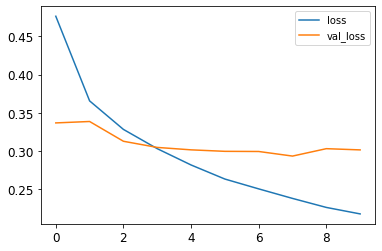

In [42]:
losses = pd.DataFrame(history.history)
losses[['loss', 'val_loss']].plot()

# Gradient Clipping
- **Gridient Clipping** is another technique to lessen the **exploding gradient** problem by **clipping the gradient duing backpropagation.**
- In Keras, implementing Gradient Clipping is just a matter of setting the `clipvalue` or `clipnorm` argument when creating an optimizer.
    - Note: If you want to ensure that Gradient Clipping **preserves the direction of the gradient vector**, you should clip by norm by setting **`clipnorm`** instead of clipvalue.

In [43]:
optimizer = keras.optimizers.SGD(clipvalue=1.0)

In [44]:
optimizer = keras.optimizers.SGD(clipnorm=1.0)

# Reusing Pretrained Layers
- When training neural networks, we should always try to find an **existing neural network** that accomplishes a similar task to the one you are trying to tackle, then just **reuse the lower layers** of this network: this is called **transfer learning**. 
    - It will not only speed up training considerably, but will also require much less training data.
- The right number of layers to reuse
    - Try **freezing all** the reused layers first (i.e., make their weights non-trainable, so gradient descent won’t modify them), then train your model and see how it performs.
    - Then try **unfreezing one or two of the top hidden layers** to let backpropagation tweak them and see if performance improves.
        - The more training data available, the more layers you can unfreeze.
        - It is also useful to **reduce the learning rate** when you unfreeze reused layers: this will avoid wrecking their fine-tuned weights.
    - If you still cannot get good performance, and you have little training data, try **dropping the top hidden layer(s)** and **freeze all remaining hidden layers** again.

## Reusing a Keras Model
- Let's split the Fashion MNIST dataset in two:
    - `X_train_A`: all images of all items except for sandals and shirts (classes 5 and 6).
    - `X_train_B`: a much smaller training set of just the first 200 images of sandals or shirts.
- The validation set and the test set are also split this way, but without restricting the number of images. 
- We will train a model on set A (classification task with 8 classes), and try to reuse it to tackle set B (binary classification). 
     - We hope to transfer a little bit of knowledge from task A to task B, since classes in set A (sneakers, ankle boots, coats, t-shirts, etc.) are somewhat similar to classes in set B (sandals and shirts). 
     - However, since we are using Dense layers, only patterns that occur at the same location can be reused (in contrast, convolutional layers will transfer much better, since learned patterns can be detected anywhere on the image, as we will see in the CNN chapter).

In [45]:
def split_dataset(X, y):
    y_5_or_6 = (y == 5) | (y == 6) # sandals or shirts
    y_A = y[~y_5_or_6]
    y_A[y_A > 6] -= 2 # class indices 7, 8, 9 should be moved to 5, 6, 7
    y_B = (y[y_5_or_6] == 6).astype(np.float32) # binary classification task: is it a shirt (class 6)?
    
    return ((X[~y_5_or_6], y_A),
            (X[y_5_or_6], y_B))

In [46]:
(X_train_A, y_train_A), (X_train_B, y_train_B) = split_dataset(X_train, y_train)
(X_valid_A, y_valid_A), (X_valid_B, y_valid_B) = split_dataset(X_valid, y_valid)
(X_test_A, y_test_A), (X_test_B, y_test_B) = split_dataset(X_test, y_test)
X_train_B = X_train_B[:200]
y_train_B = y_train_B[:200]

In [47]:
X_train_A.shape

(43986, 28, 28)

In [48]:
X_train_B.shape

(200, 28, 28)

In [49]:
tf.random.set_seed(42)
np.random.seed(42)

In [50]:
model_A = keras.models.Sequential()

model_A.add(keras.layers.Flatten(input_shape=[28, 28]))

for n_hidden in (300, 100, 50, 50, 50):
    model_A.add(keras.layers.Dense(n_hidden, activation='selu'))

model_A.add(keras.layers.Dense(8, activation='softmax'))

In [51]:
model_A.compile(loss='sparse_categorical_crossentropy', optimizer=keras.optimizers.SGD(lr=1e-3),
               metrics=['accuracy'])

In [52]:
history = model_A.fit(X_train_A, y_train_A, epochs=10, validation_data=(X_valid_A, y_valid_A))

Train on 43986 samples, validate on 4014 samples
Epoch 1/10
43986/43986 [==============================] - 13s 302us/sample - loss: 0.5909 - accuracy: 0.8100 - val_loss: 0.3772 - val_accuracy: 0.8707
Epoch 2/10
43986/43986 [==============================] - 12s 277us/sample - loss: 0.3521 - accuracy: 0.8793 - val_loss: 0.3394 - val_accuracy: 0.8779
Epoch 3/10
43986/43986 [==============================] - 12s 273us/sample - loss: 0.3167 - accuracy: 0.8890 - val_loss: 0.3018 - val_accuracy: 0.8959
Epoch 4/10
43986/43986 [==============================] - 11s 259us/sample - loss: 0.2969 - accuracy: 0.8967 - val_loss: 0.2858 - val_accuracy: 0.9031
Epoch 5/10
43986/43986 [==============================] - 12s 281us/sample - loss: 0.2824 - accuracy: 0.9030 - val_loss: 0.2808 - val_accuracy: 0.9071
Epoch 6/10
43986/43986 [==============================] - 12s 278us/sample - loss: 0.2720 - accuracy: 0.9073 - val_loss: 0.2683 - val_accuracy: 0.9103
Epoch 7/10
43986/43986 [=====================

- Let's create a new model that's entirely new and for task B.

In [53]:
model_B = keras.models.Sequential()
model_B.add(keras.layers.Flatten(input_shape=[28, 28]))
for n_hidden in (300, 100, 50, 50, 50):
    model_B.add(keras.layers.Dense(n_hidden, activation="selu"))
model_B.add(keras.layers.Dense(1, activation="sigmoid"))

In [54]:
model_B.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1e-3),
                metrics=["accuracy"])

In [55]:
history = model_B.fit(X_train_B, y_train_B, epochs=10,
                      validation_data=(X_valid_B, y_valid_B))

Train on 200 samples, validate on 986 samples
Epoch 1/10
200/200 [==============================] - 2s 9ms/sample - loss: 0.9545 - accuracy: 0.4600 - val_loss: 0.6655 - val_accuracy: 0.5385
Epoch 2/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.5899 - accuracy: 0.6900 - val_loss: 0.4785 - val_accuracy: 0.8519
Epoch 3/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.4512 - accuracy: 0.8800 - val_loss: 0.4098 - val_accuracy: 0.8945
Epoch 4/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.3871 - accuracy: 0.9100 - val_loss: 0.3666 - val_accuracy: 0.9128
Epoch 5/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.3438 - accuracy: 0.9250 - val_loss: 0.3315 - val_accuracy: 0.9300
Epoch 6/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.3095 - accuracy: 0.9300 - val_loss: 0.3034 - val_accuracy: 0.9402
Epoch 7/10
200/200 [==============================] - 0s 1ms/sample - loss: 0.2810 - accur

- Now, let's create a new model based on the model A’s layers. 
    - Let’s reuse all layers except for the output layer.

In [56]:
model_B_on_A = keras.models.Sequential(layers=model_A.layers[:-1])
model_B_on_A.add(keras.layers.Dense(1, activation='sigmoid'))

- When you **train model_B_on_A**, it will also **affect model_A**. 
- If you want to avoid that, you need to **clone model_A** before you reuse its layers. 
    - To do this, you must clone model A’s architecture, then copy its weights (since `clone_model()` does not clone the weights).

In [57]:
model_A_clone = keras.models.clone_model(model_A)
model_A_clone.set_weights(model_A.get_weights())

- Now we could just train model_B_on_A for task B, but since the **new output layer** was **initialized randomly**, it will make large errors, at least during the first few epochs, so there will be large error gradients that may wreck the reused weights. 
- To avoid this, one approach is to **freeze the reused layers** during the **first few epochs**, giving the new layer some time to learn reasonable weights. 
    - To do this, simply set every layer’s `trainable` attribute to False and compile the model.

In [58]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=False
    
model_B_on_A.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, validation_data=(X_valid_B, y_valid_B), epochs=5)

Train on 200 samples, validate on 986 samples
Epoch 1/5
200/200 [==============================] - 2s 8ms/sample - loss: 0.1862 - accuracy: 0.9650 - val_loss: 0.1896 - val_accuracy: 0.9797
Epoch 2/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.1594 - accuracy: 0.9800 - val_loss: 0.1661 - val_accuracy: 0.9828
Epoch 3/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.1375 - accuracy: 0.9800 - val_loss: 0.1469 - val_accuracy: 0.9838
Epoch 4/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.1199 - accuracy: 0.9850 - val_loss: 0.1310 - val_accuracy: 0.9848
Epoch 5/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.1052 - accuracy: 0.9850 - val_loss: 0.1182 - val_accuracy: 0.9848


- Next, we can **unfreeze the reused layers** (which requires **compiling the model again**) and continue training to fine-tune the reused layers for task B. 
- After unfreezing the reused layers, it is usually a good idea to **reduce the learning rate**, once again to avoid damaging the reused weights.

In [59]:
for layer in model_B_on_A.layers[:-1]:
    layer.trainable=True
    
model_B_on_A.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

history = model_B_on_A.fit(X_train_B, y_train_B, validation_data=(X_valid_B, y_valid_B), epochs=5)

Train on 200 samples, validate on 986 samples
Epoch 1/5
200/200 [==============================] - 2s 9ms/sample - loss: 0.0462 - accuracy: 0.9900 - val_loss: 0.0357 - val_accuracy: 0.9899
Epoch 2/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.0022 - accuracy: 1.0000 - val_loss: 0.2034 - val_accuracy: 0.9675
Epoch 3/5
200/200 [==============================] - 0s 1ms/sample - loss: 0.0180 - accuracy: 0.9950 - val_loss: 0.0822 - val_accuracy: 0.9878
Epoch 4/5
200/200 [==============================] - 0s 1ms/sample - loss: 5.2796e-05 - accuracy: 1.0000 - val_loss: 0.0396 - val_accuracy: 0.9909
Epoch 5/5
200/200 [==============================] - 0s 1ms/sample - loss: 2.9584e-05 - accuracy: 1.0000 - val_loss: 0.0283 - val_accuracy: 0.9970


- Now, let's compare `model_B_on_A` with `model_B`.

In [60]:
model_B.evaluate(X_test_B, y_test_B, verbose=0)

[0.22956316041946412, 0.955]

In [61]:
model_B_on_A.evaluate(X_test_B, y_test_B, verbose=0)

[0.007541129923303742, 0.997]

- As we can see, `model_B_on_A` outperforms `model_B` significantly.
- However, keep in mind that transfer learning generally does not work very well with small dense networks: it works best with deep convolutional neural networks.

# Unsupervised Pretraining
- In the case where you don’t have much labeled training data, and you cannot find a model trained on a similar task, you may still be able to perform **unsupervised pretraining** if you can find enough unlabeled training data.
- You can try to **train the layers one by one**, starting with the lowest layer and then going up, using an **unsupervised feature detector algorithm** such as **Restricted Boltzmann Machines (RBMs)** or **autoencoders**. 
    - Each layer is trained on the output of the previously trained layers (all layers except the one being trained are **frozen**). 
- Once all layers have been trained this way, you can **add the output layer** for your task, and fine-tune the final network using supervised learning (i.e., with the labeled training examples). 
    - At this point, you can **unfreeze** all the pretrained layers, or just some of the upper ones.
    
# Pretraining on an Auxiliary Task
- If you do not have much labeled training data, one last option is to train a first neural network on an auxiliary task.

# Faster Optimizers
- Training a very large deep neural network can be painfully slow. 
- So far, we have seen 4 ways to speed up training (and reach a better solution): 
    - Applying a **good initialization strategy** for the connection weights
    - Using a **good activation function**
    - Using **Batch Normalization**
    - Reusing parts of a **pretrained network** 
        - Possibly built on an auxiliary task 
        - Or using unsupervised learning
- Another huge speed boost comes from using a **faster optimizer** than the regular Gradient Descent optimizer.

## Momentum Optimization
- Recall that **regular Gradient Descent** will simply take small regular steps down the slope, as the algorithm simply updates the weights $\theta$ by directly subtracting the gradient of the cost function $J(\theta)$ with regards to the weights $(\nabla_{\theta} J(\theta))$ multiplied by the learning rate $\eta$.
    - $\theta \leftarrow \theta - \eta \nabla_{\theta} J(\theta)$
- **Momentum optimization** cares a great deal about what **previous gradients** were. 
- At each iteration, it subtracts the local gradient from the **momentum vector** $m$ (multiplied by the learning rate $\eta$), and it updates the weights by simply adding this momentum vector.
    - $m \leftarrow \beta m - \eta \nabla_{\theta} J(\theta)$
    - $\theta \leftarrow \theta + m$
        - $\beta$ is the new hyperparamter **momentum** with values between 0 and 1 (typical value is 0.9).
- Although Momentum optimization adds another hyperparameter to tune, the **momentum value of 0.9** usually works well in practice and almost always goes faster than regular Gradient Descent.
- To implement momentum optimization using Keras, just use the **SGD optimizer** and set its `momentum` hyperparameter.

In [62]:
keras.optimizers.SGD(lr=1e-3, momentum=0.9)

## Nesterov Accelerated Gradient (NAG)
- One small variant to Momentum optimization, almost always **faster than vanilla Momentum optimization**. 
- The idea of **Nesterov Momentum optimization**, or **Nesterov Accelerated Gradient (NAG)**, is to measure the gradient of the cost function not at the local position but slightly ahead in the direction of the momentum. 
    - The only difference from vanilla Momentum optimization is that the gradient is measured at $\theta + \beta m$ rather than at $\theta$.
        - $m \leftarrow \beta m - \nabla_{\theta}J(\theta + \beta m) \times \eta$
        - $\theta \leftarrow \theta + m$
- To use it, simply set `nesterov=True` when creating the **SGD** optimizer.

In [63]:
keras.optimizers.SGD(lr=1e-3, nesterov=True)

## AdaGrad
- The AdaGrad algorithm **corrects its direction** to point a bit more toward the **global optimum** by **scaling down the gradient vector** along the steepest dimensions.
- The first step of the algorithm accumulates the square of the gradient, and the second step scales down the gradient vector.
    - $s \leftarrow s + \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$
    - $\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s + \epsilon}$
- In short, this algorithm **decays the learning rate**, but it does so **faster for steep dimensions** than for dimensions with gentler slopes. 
    - This is called an **adaptive learning rate**.
- Note that AdaGrad tends to stop too early when training deep neural networks.
    - So even though Keras has an Adagrad optimizer, you should **NOT** use it to train **deep neural networks**.

In [64]:
keras.optimizers.Adagrad(lr=1e-3)

## RMSProp
- Although AdaGrad slows down a bit too fast and ends up never converging to the global optimum, the RMSProp algorithm fixes this by **accumulating only the gradients** from **the most recent iterations** (as opposed to all the gradients since the beginning of training). 
    - $s \leftarrow \beta s + (1-\beta) \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$
    - $\theta \leftarrow \theta - \eta \nabla_{\theta}J(\theta) \oslash \sqrt{s + \epsilon}$
        - $\beta$ is the decay rate, typically set 0.9.
- The RMSProp optimizer almost always performs much better than AdaGrad.
- To implement RMSProp, we can use the `RMSProp` optimizer from Keras.

In [65]:
keras.optimizers.RMSprop(lr=0.01, rho=0.9)

## Adam and Nadam Optimization
- **Adam**, which stands for **adaptive moment estimation**, combines the ideas of **Momentum optimization** and **RMSProp**.
    - Just like Momentum optimization it keeps track of an **exponentially decaying average of past gradients**
    - Just like RMSProp it keeps track of an **exponentially decaying average of past squared gradients**.
- The Adam algorithm
    1. $m \leftarrow \beta_1 m - (1-\beta_1) \nabla_{\theta}J(\theta)$
    2. $s \leftarrow \beta_2 s + (1-\beta_2) \nabla_{\theta}J(\theta) \otimes \nabla_{\theta}J(\theta)$
    3. $\hat{m} \leftarrow \frac{m}{1-{\beta_1}^t}$
    4. $\hat{s} \leftarrow \frac{s}{1-{\beta_2}^t}$
    5. $\theta \leftarrow \theta + \eta \hat{m} \oslash \sqrt{\hat{s}+\epsilon}$
        - The momentum decay hyperparameter $\beta_1$ is typically initialized to 0.9.
        - The scaling decay hyperparameter $\beta_2$ is often initialized to 0.999. 
        - As earlier, the smoothing term $\epsilon$ is usually initialized to a tiny number such as $10^{-7}$.
- To implement Adam optimization, we can use the `Adam` class from Keras.

In [66]:
keras.optimizers.Adam()

- **Nadam optimization** is simply **Adam optimization** plus the **Nesterov trick**, so it will often **converge slightly faster** than Adam.

In [67]:
keras.optimizers.Nadam()

# Learning Rate Scheduling
- Finding the optimal learning rate is tricky, and wee can do better than a constant learning rate.
    - If you start with a high learning rate and then reduce it once it stops making fast progress, you can reach a good solution faster than with the optimal constant learning rate. 
- There are many different **strategies to reduce the learning rate** during training, which are called **learning schedules**.

## Power Scheduling
- $\eta(t) = \frac{\eta_0}{(1+t/k)^c}$
- This schedule first drops quickly, then more and more slowly as $t$ increases.
- Implementing power scheduling in Keras is the easiest option: just set the `decay` hyperparameter when creating an optimizer. 
    - The `decay` is the inverse of $k$ (the number of steps it takes to divide the learning rate by one more unit), and Keras assumes that $c$ is equal to 1.

In [68]:
keras.optimizers.SGD(lr=0.01, decay=1/10000)

## Exponential Scheduling
- $\eta(t) = \eta_0 0.1^{t/s}$
- The learning rate will gradually drop by a factor of 10 every $s$ steps.
- To implement exponential scheduling:
    - First, define a function that takes the current epoch and returns the learning rate
    - Next, create a **`LearningRateScheduler` callback**, giving it the schedule function, and pass this callback to the `fit()` method

In [69]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0*0.1**(epoch/s)
    return exponential_decay_fn

In [70]:
exponential_decay_fn = exponential_decay(lr0=0.01, s=20)

In [71]:
exp_scheduler = keras.callbacks.LearningRateScheduler(exponential_decay_fn)

In [72]:
# history = model.fit(X_train, y_train, ..., callbacks=[exp_scheduler])

- The schedule function can take the **current learning rate** as a second argument.

In [73]:
 def exponential_decay_fn(epoch, lr):
        return lr*0.1**(1/20)

- If you want to **update the learning rate at each iteration** rather than each epoch, you must write your own **callback class**.

In [74]:
K = keras.backend

class ExponentialDecay(keras.callbacks.Callback):
    def __init__(self, s=40000):
        super().__init__()
        self.s = s
        
    def on_batch_begin(self, batch, logs=None):
        lr = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, lr*0.1**(1/s))
        
    def on_epoch_end(self, epoch, logs=None):
        logs = logs or {}
        logs['lr'] = K.get_value(self.model.optimizer.lr)

In [75]:
s = 20 * len(X_train) // 32   # number of steps in 20 epochs, given batch size is 32 (one batch in each step)

exp_decay = ExponentialDecay(s)

# history = model.fit(X_train, y_train, ..., callbacks=[exp_decay])

## Piecewise Constant Scheduling
- Use a constant learning rate for a number of epochs (e.g. $\eta_0=0.1$ for 5 epochs), then a smaller learning rate for another number of epochs (e.g. $\eta_1=0.001$ for 50 epochs), and so on.
- To implement Piecewise Constant Scheduling, we can use a **schedule function** as earlier, then create a **`LearningRateScheduler` callback** with this function.

In [76]:
def piecewise_constant_fn(epoch):
    if epoch < 5:
        return 0.01
    elif epoch < 15:
        return 0.005
    else:
        return 0.001

In [77]:
piecewise_constant_scheduler = keras.callbacks.LearningRateScheduler(piecewise_constant_fn)

In [78]:
# history = model.fit(X_train, y_train, ..., callbacks=[piecewise_constant_scheduler])

## Performance Scheduling
- Measure the validation error every $N$ steps, and reduce the learning rate by a factor $\lambda$ when the error stops dropping.
- To implement performance scheduling, simply use the **`ReduceLROnPlateau` callback**. 
    - The following callback will multiply the learning rate by 0.5 ($\lambda = 0.5$) whenever the best validation loss does not improve for 5 consecutive epochs.

In [79]:
performance_scheduler = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=5)

# history = model.fit(X_train, y_train, ..., callbacks=[performance_scheduler])

## tf.keras Schedulers
- Lastly, **tf.keras** offers an alternative way to implement learning rate scheduling: just define the learning rate using one of the schedules available in `keras.optimisers.schedules`, then pass this learning rate to any optimizer.
- This approach updates the learning rate at **each step** rather than at each epoch.

In [80]:
n_epochs = 20
batch_size = 32

s = n_epochs * len(X_train) // batch_size

learning_rate = keras.optimizers.schedules.ExponentialDecay(initial_learning_rate=0.01, 
                                                            decay_steps=s, decay_rate=0.1)
exp_optimizer = keras.optimizers.SGD(learning_rate)

# model.compile(loss='sparse_categorical_crossentropy', optimizer=exp_optimizer, metrics=['accuracy'])

# history = model.fit(X_train, y_train, ..., epochs=n_epochs)

# Avoiding Overfitting through Regularization
## $l_1$ and $l_2$ Regularization
- Just like you did in Chapter 4 for simple linear models, you can use $l_1$ and $l_2$ regularization.
- We implement $l_1$ and $l_2$ regularizations using `keras.regularizers.l1()` and `keras.regularizers.l2()`.
    - We need to specify the **regularization factor**.
    - These functions will compute the regularization loss at each step during training, which is then added to the final loss.
- If you want **both $l_1$ and $l_2$ regularization**, use `keras.regularizers.l1_l2()`, specifying both regularization factors.

In [81]:
keras.layers.Dense(100, activation="elu", kernel_initializer="he_normal", 
                   kernel_regularizer=keras.regularizers.l2(0.01))

- Since you will typically want to apply the **same regularizer, activation function, and initialization strategy** to **all layers** in your network, you may find yourself repeating the same arguments over and over.
- To avoid this, you can try refactoring your code to use loops. 
- Another option is to use Python’s `functools.partial()` function.
    - It lets you create a thin wrapper for any callable, with some default argument values.

In [82]:
from functools import partial

In [83]:
RegularizedDense = partial(keras.layers.Dense,
                          activation='elu',
                          kernel_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(0.01))

In [84]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(RegularizedDense(300))
model.add(RegularizedDense(300))
model.add(RegularizedDense(300))

model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform'))

## Dropout
- Dropout is one of the most popular regularization techniques for deep neural networks.
- It is a fairly simple algorithm: 
    - At **every training step**, every neuron (including the **input neurons**, but always excluding the output neurons) has a **probability $p$** of being temporarily “dropped out,” meaning it will be **entirely ignored** during this training step, but it may be active during the next step. 
    - The hyperparameter $p$ is called the **dropout rate**, and it is typically set to 50%.
- There is one small but important technical detail: Suppose p = 50%, in which case during testing a neuron will be connected to twice as many input neurons as it was (on average) during training. 
    - To compensate for this fact, we need to **multiply each input connection weight** by the **keep probability** $(1 – p)$ after training. 
    - Alternatively, we can **divide each neuron’s output** by the **keep probability** during training.
- To implement dropout using Keras, you can use the `keras.layers.Dropout` layer.
    - During training, it randomly drops some inputs (setting them to 0) and divides the remaining inputs by the keep probability.

In [85]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(keras.layers.Dropout(0.5))

model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform'))

## Monte-Carlo (MC) Dropout
- To implement MC Dropout, we first **force training mode on**, using a `learning_phase_scope(1)` context. 
    - This turns dropout on within the `with` block. 
- Then we **make 100 predictions** over the test set, and we **stack them**. 
    - Since dropout is on, all predictions will be different. 
    - Recall that `predict()` returns a matrix with one row per instance, and one column per class.
    - Since there are 10,000 instances in the test set, and 10 classes, this is a matrix of shape [10000, 10]. 
    - We stack 100 such matrices, so y_probas is an array of shape [100, 10000, 10]. 
- Once we average over the first dimension (`axis=0`), we get `y_proba`, an array of shape [10000, 10], like we would get with a single prediction.

In [86]:
# with keras.backend.learning_phase_scope(1):
#     y_probas = np.stack([model.predict(X_test_scaled) for sample in range(100)])

# y_proba = y_probas.mean(axis=0)

- If your model contains **other layers that behave in a special way** during training (such as **Batch Normalization layers**), then you should NOT force training mode like we just did. 
- Instead, you should replace the Dropout layers with the following **MCDropout class**.
    - We just sublass the Dropout layer and override the `call()` method to force its `training` argument to True.

In [87]:
class MCDropout(keras.layers.Dropout):
    def call(self, inputs):
        return super().call(inputs, training=True)

- If you are creating a model from scratch, it’s just a matter of using `MCDropout` rather than `Dropout`.

In [88]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(MCDropout(0.5))
model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(MCDropout(0.5))
model.add(keras.layers.Dense(300, activation='elu', kernel_initializer='he_normal'))
model.add(MCDropout(0.5))

model.add(keras.layers.Dense(10, activation='softmax', kernel_initializer='glorot_uniform'))

In [89]:
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_dropout (MCDropout)       (None, 300)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 300)               90300     
_________________________________________________________________
mc_dropout_1 (MCDropout)     (None, 300)               0         
_________________________________________________________________
dense_242 (Dense)            (None, 300)               90300     
_________________________________________________________________
mc_dropout_2 (MCDropout)     (None, 300)             

- If you have a model that was already trained using `Dropout`, you need to create a new model identical to the existing model except replacing the `Dropout` layers with `MCDropout`, then copy the existing model’s weights to your new model.

In [90]:
mc_model = keras.models.Sequential([
    MCDropout(layer.rate) if isinstance(layer, keras.layers.Dropout) else layer for layer in model.layers
])

In [91]:
mc_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_10 (Flatten)         (None, 784)               0         
_________________________________________________________________
dense_240 (Dense)            (None, 300)               235500    
_________________________________________________________________
mc_dropout_3 (MCDropout)     (None, 300)               0         
_________________________________________________________________
dense_241 (Dense)            (None, 300)               90300     
_________________________________________________________________
mc_dropout_4 (MCDropout)     (None, 300)               0         
_________________________________________________________________
dense_242 (Dense)            (None, 300)               90300     
_________________________________________________________________
mc_dropout_5 (MCDropout)     (None, 300)             

In [92]:
mc_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [93]:
history = mc_model.fit(X_train_scaled, y_train, validation_data=(X_valid_scaled, y_valid), epochs=3)

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 25s 462us/sample - loss: 1.0600 - accuracy: 0.7161 - val_loss: 0.6135 - val_accuracy: 0.7926
Epoch 2/3
55000/55000 [==============================] - 24s 442us/sample - loss: 0.5843 - accuracy: 0.7939 - val_loss: 0.5780 - val_accuracy: 0.7980
Epoch 3/3
55000/55000 [==============================] - 24s 440us/sample - loss: 0.5655 - accuracy: 0.8054 - val_loss: 0.5299 - val_accuracy: 0.8216


In [94]:
np.round(model.predict(X_test_scaled[:1]), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.04, 0.  , 0.95]],
      dtype=float32)

In [95]:
np.round(np.mean([mc_model.predict(X_test_scaled[:1]) for sample in range (100)], axis=0), 2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.1 , 0.  , 0.12, 0.  , 0.78]],
      dtype=float32)

## Max-Norm Regularization
- For **each neuron**, it **constrains the weights** $w$ of the incoming connections such that $\left\|w \right\|_2 \leq r$, where $r$ is the max-norm hyperparameter and $\left\|w \right\|_2$ is the $l_2$ norm.
- Max-norm regularization does not add a regularization loss term to the overall loss function. 
    - Instead, it is typically implemented by computing $\left\|w \right\|_2$ after each training step and clipping $w$ if needed ($w \leftarrow w\frac{r}{\left\|w \right\|_2}$).
    - Reducing $r$ increases the amount of regularization and helps reduce overfitting.
- To implement max-norm regularization in Keras, just set every hidden layer’s `kernel_constraint` argument to a `max_norm()` constraint, with the appropriate max value.

In [96]:
layer = keras.layers.Dense(100, activation='selu', kernel_initializer='lecun_normal',
                          kernel_constraint=keras.constraints.max_norm(1.0))

- Now, let's build an ANN model using Max-Norm regularization using the `functools.partial()` function as before.

In [97]:
MaxNormDense = partial(keras.layers.Dense,
                      activation='selu',
                      kernel_initializer='lecun_normal',
                      kernel_constraint=keras.constraints.max_norm(1.0))

In [98]:
model = keras.models.Sequential()

model.add(keras.layers.Flatten(input_shape=[28, 28]))

model.add(MaxNormDense(300))
model.add(MaxNormDense(100))

model.add(keras.layers.Dense(10, activation='softmax'))

In [99]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])

In [100]:
history = model.fit(X_train_scaled, y_train, epochs=3, validation_data=(X_valid_scaled, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/3
55000/55000 [==============================] - 22s 402us/sample - loss: 0.4761 - accuracy: 0.8338 - val_loss: 0.3973 - val_accuracy: 0.8544
Epoch 2/3
55000/55000 [==============================] - 21s 379us/sample - loss: 0.3584 - accuracy: 0.8691 - val_loss: 0.3782 - val_accuracy: 0.8672
Epoch 3/3
55000/55000 [==============================] - 21s 382us/sample - loss: 0.3280 - accuracy: 0.8785 - val_loss: 0.3497 - val_accuracy: 0.8752


In [101]:
model.evaluate(X_test_scaled, y_test, verbose=0)

[0.37800401457548144, 0.8634]

# Summary and Practical Guidelines
- The configuration below will work fine in most cases, without requiring much hyperparameter tuning.
    - Kernel initializer: **LeCun Initialization**
    - Activation function: **SELU**
    - Normalization: None (self-normalization)
    - Regularization: **Early Stopping**
    - Optimizer: **Nadam**
    - Learning rate schedule: **Performance Scheduling**
    - Also, don't forget to **standardize the input features**.

# Exercises
## 8. Deep Learning
- This exercise requires fitting models for hundreds of epochs, which is highly computationaly-expensive.
- For the sample code, visit: https://github.com/ageron/handson-ml2/blob/master/11_training_deep_neural_networks.ipynb